# End-to-End Camera Calibration

Simulated data to support the idea of end-to-end camera transformation.

For details on the idea, see [the doc](https://docs.google.com/document/d/1-ikSOxtrC4HLzd8xBdokjfMbbz0616eOBsco-bDk3os/edit)

This version of the notebook includes tag height in the simulated data, to provide better distance precision.

### Imports

In [59]:
import time
import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as interp

np.set_printoptions(precision=2, floatmode='fixed', suppress=True, threshold=10, edgeitems=10)

### Real world points

In [60]:
# open cv world coords: x right, y down, z forward.
# distance 5 m side to side
x_space_cv = np.linspace(-5, 5, 21)
# y is down, and zero is at the floor
y_space_cv = np.linspace(-0.5, -1.5, 5)
# y_space_cv = np.linspace(-1, -2, 10)
# distance from 0.5 to 5 meters
z_space_cv = np.linspace(0.5, 5, 10)
X_cv, Y_cv, Z_cv = np.meshgrid(x_space_cv, y_space_cv, z_space_cv)
X_cv = X_cv.reshape(1, -1).T
Y_cv = Y_cv.reshape(1, -1).T
Z_cv = Z_cv.reshape(1, -1).T

### Camera intrinsics and pose

In [61]:
# intrinsic matrix
K = np.array([[300.0, 0.0, 250.0], [0.0, 300.0, 250.0], [0.0, 0.0, 1.0]])

# distortion coefficients (k1, k2, p1, p2, k3)
# A LOT of distortion, in order to see it work.
distCoeffs = np.array([1.5, -0.95, -0.005, 0.0025, 1.16])
# distCoeffs = np.array([0.0, 0.0, 0.0, 0.0, 0.0])

# world in camera coordinates: camera up means world down.
rvec = np.array([-0.4, 0.0, 0.0])
# camera is 0.5m up (negative) from the floor, which means world is 0.5m down (positive)
tvec = np.array([0.0, 0.2, 0.0])

### Project points to pixels, (u, v)

For each tag height, the points look like a "ceiling" above the camera

[[-5.17e+08 -6.81e+06]
 [-1.22e+07  3.14e+05]
 [-1.06e+06  6.89e+04]
 [-1.74e+05  1.83e+04]
 [-4.21e+04  6.29e+03]
 [-1.34e+04  2.73e+03]
 [-5.31e+03  1.47e+03]
 [-2.51e+03  9.63e+02]
 [-1.37e+03  7.30e+02]
 [-8.32e+02  6.13e+02]
 ...
 [ 2.17e+07 -4.29e+06]
 [ 1.57e+06 -2.48e+05]
 [ 2.27e+05 -2.69e+04]
 [ 5.01e+04 -3.77e+03]
 [ 1.50e+04 -3.69e+02]
 [ 5.86e+03  2.32e+02]
 [ 2.90e+03  3.44e+02]
 [ 1.77e+03  3.62e+02]
 [ 1.26e+03  3.63e+02]
 [ 9.92e+02  3.62e+02]]
[[2.81e+08]
 [4.65e+06]
 [3.20e+05]
 [4.44e+04]
 [9.46e+03]
 [2.70e+03]
 [9.67e+02]
 [4.14e+02]
 [2.07e+02]
 [1.18e+02]
 ...
 [8.11e+06]
 [4.31e+05]
 [4.96e+04]
 [9.08e+03]
 [2.29e+03]
 [7.41e+02]
 [2.95e+02]
 [1.41e+02]
 [7.90e+01]
 [5.10e+01]]
[[ 14.47 408.50  26.33   0.50   5.00   2.50]
 [ 20.18 398.67  30.92   0.50   4.00   2.00]
 [ 52.77 396.81  26.45   0.50   4.50   2.00]
 [ 76.90 395.71  23.24   0.50   5.00   2.00]
 [ 28.99 383.38  37.38   0.50   3.00   1.50]
 [ 67.76 383.66  31.01   0.50   3.50   1.50]
 [ 94.44 384.30  2

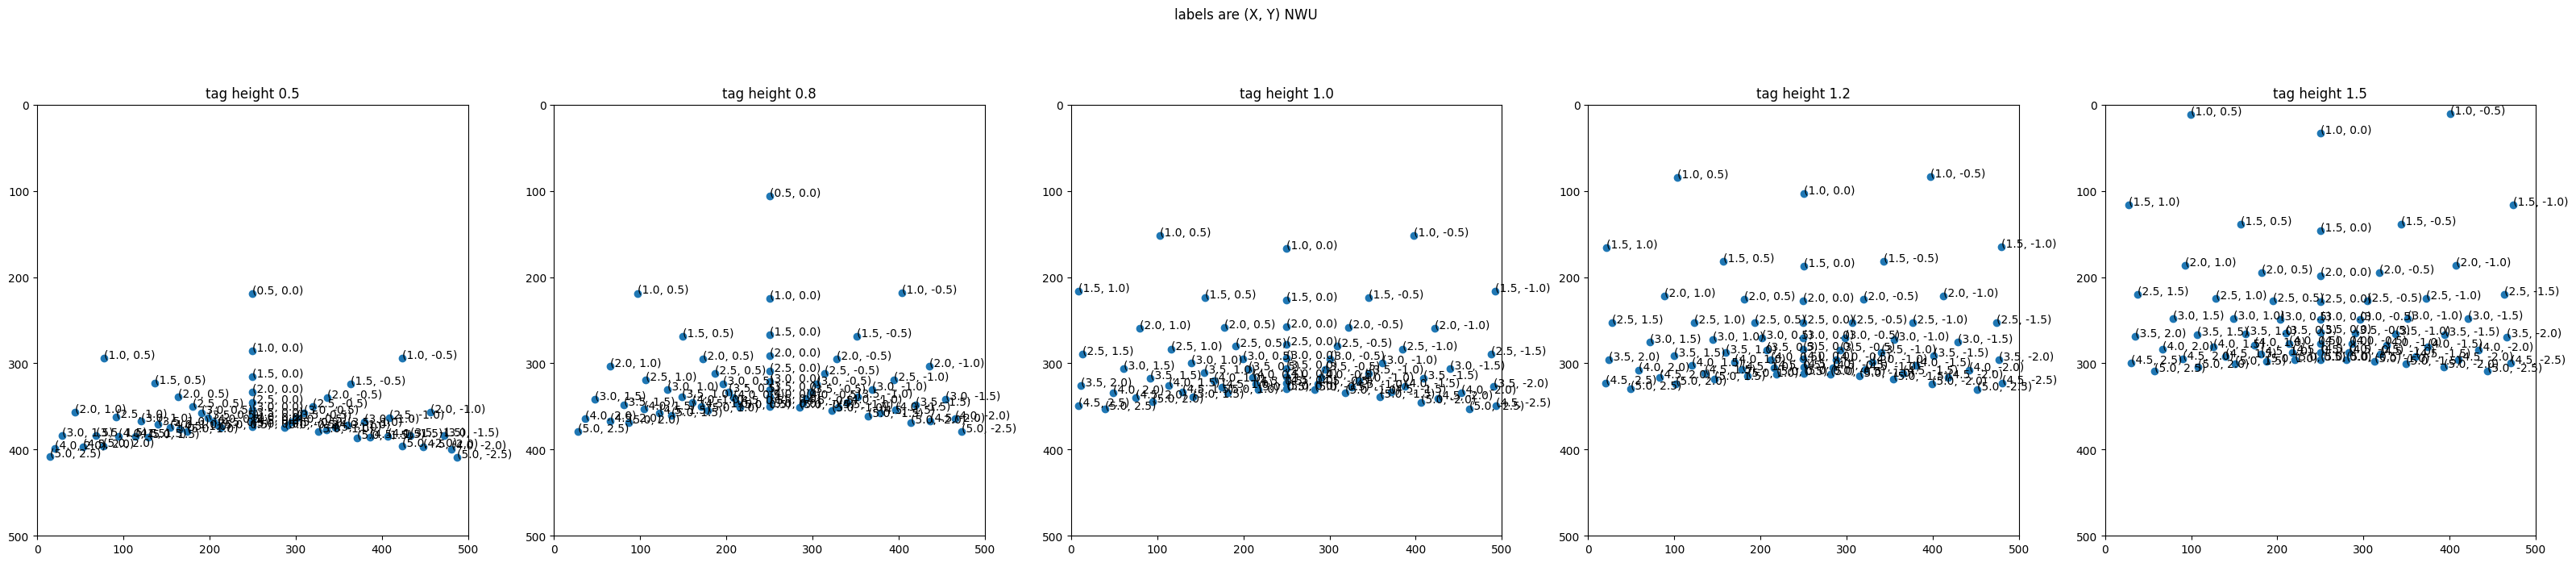

In [62]:
# these are the tag centers
XYZ_cv = np.hstack((X_cv, Y_cv, Z_cv))
# print(XYZ_cv)
U_dist, _ = cv2.projectPoints(XYZ_cv, rvec, tvec, K, distCoeffs)
# (u, v) are pixels
uv = U_dist[:, 0]

# for the purpose of this simulation let's just make another point 0.2m above the center
XYZ_cv[:,1] -= 0.2
# print(XYZ_cv)
U_dist2, _ = cv2.projectPoints(XYZ_cv, rvec, tvec, K, distCoeffs)
uv2 = U_dist2[:, 0]
print(uv)
# print(uv2)
dd = uv - uv2
d = np.hypot(dd[:,0],dd[:,1])
d = d.reshape(1, -1).T
print(d)


X_nwu = Z_cv  # ahead
Y_nwu = -X_cv  # left
Z_nwu = -Y_cv  # up

# this is the training data
uvdZXY_nwu = np.hstack((uv, d, Z_nwu, X_nwu, Y_nwu))
uvdZXY_nwu = uvdZXY_nwu[
    (uvdZXY_nwu[:, 0] >= 0)
    & (uvdZXY_nwu[:, 1] >= 0)
    & (uvdZXY_nwu[:, 0] <= 500)
    & (uvdZXY_nwu[:, 1] <= 500)
]
print(uvdZXY_nwu)

fig, ax = plt.subplots(1, y_space_cv.size, figsize=(40, 8))
fig.suptitle("labels are (X, Y) NWU")

for i, tag_height in enumerate(y_space_cv):
    for_height = uvdZXY_nwu[np.isclose(uvdZXY_nwu[:, 3], -tag_height)]
    print(for_height)
    uuu = for_height.T[0]
    vvv = for_height.T[1]
    ax[i].scatter(uuu, vvv)
    ax[i].set_title(f"tag height {-tag_height:.1f}")
    ax[i].set_aspect("equal")
    ax[i].set_xlim(0, 500)
    ax[i].set_ylim(0, 500)
    ax[i].invert_yaxis()  # camera y is positive-down
    for ii, row in enumerate(for_height):
        ax[i].annotate(f"({0.0+row[4]:.1f}, {0.0+row[5]:.1f})", (row[0], row[1]))

plt.show()

### Predict XZ (robot-relative Translation2d)  from simulated uvY

This uses (X, Y, Z) robot-relative NWU coordinates and (u, v) pixels

This just uses the linear interpolator because it's better; see the other notebook if you want to see the RBF one.


In [63]:
uvdZ_nwu_to_XY_nwu_linear = interp.LinearNDInterpolator(uvdZXY_nwu[:,(0,1,2,3)], uvdZXY_nwu[:,(4,5)])



### What do these functions look like?

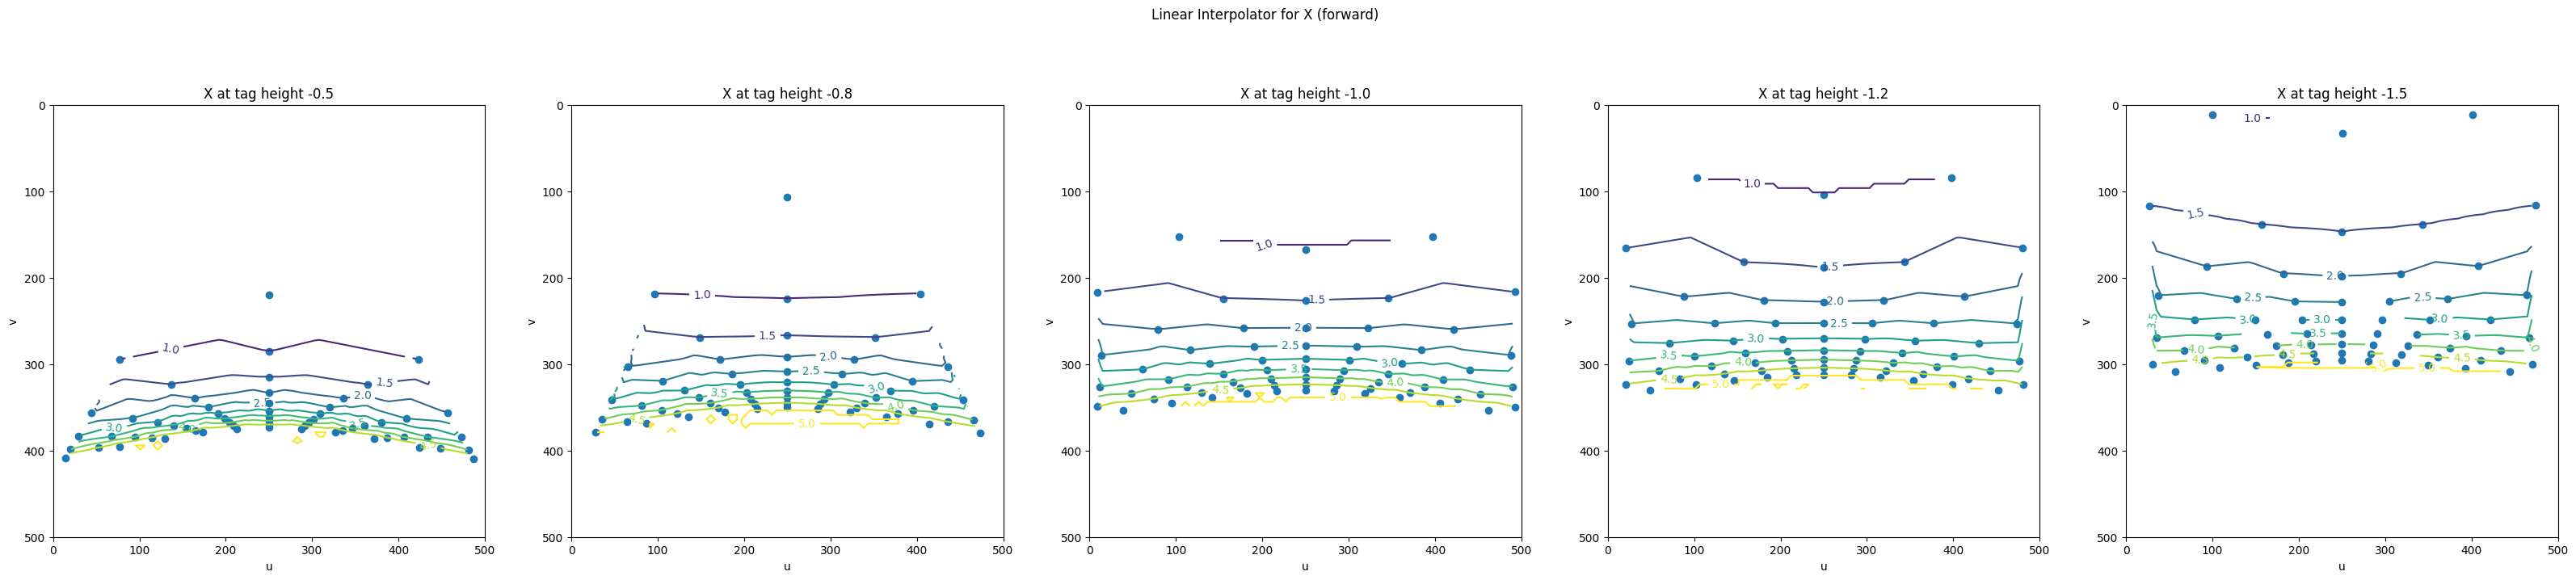

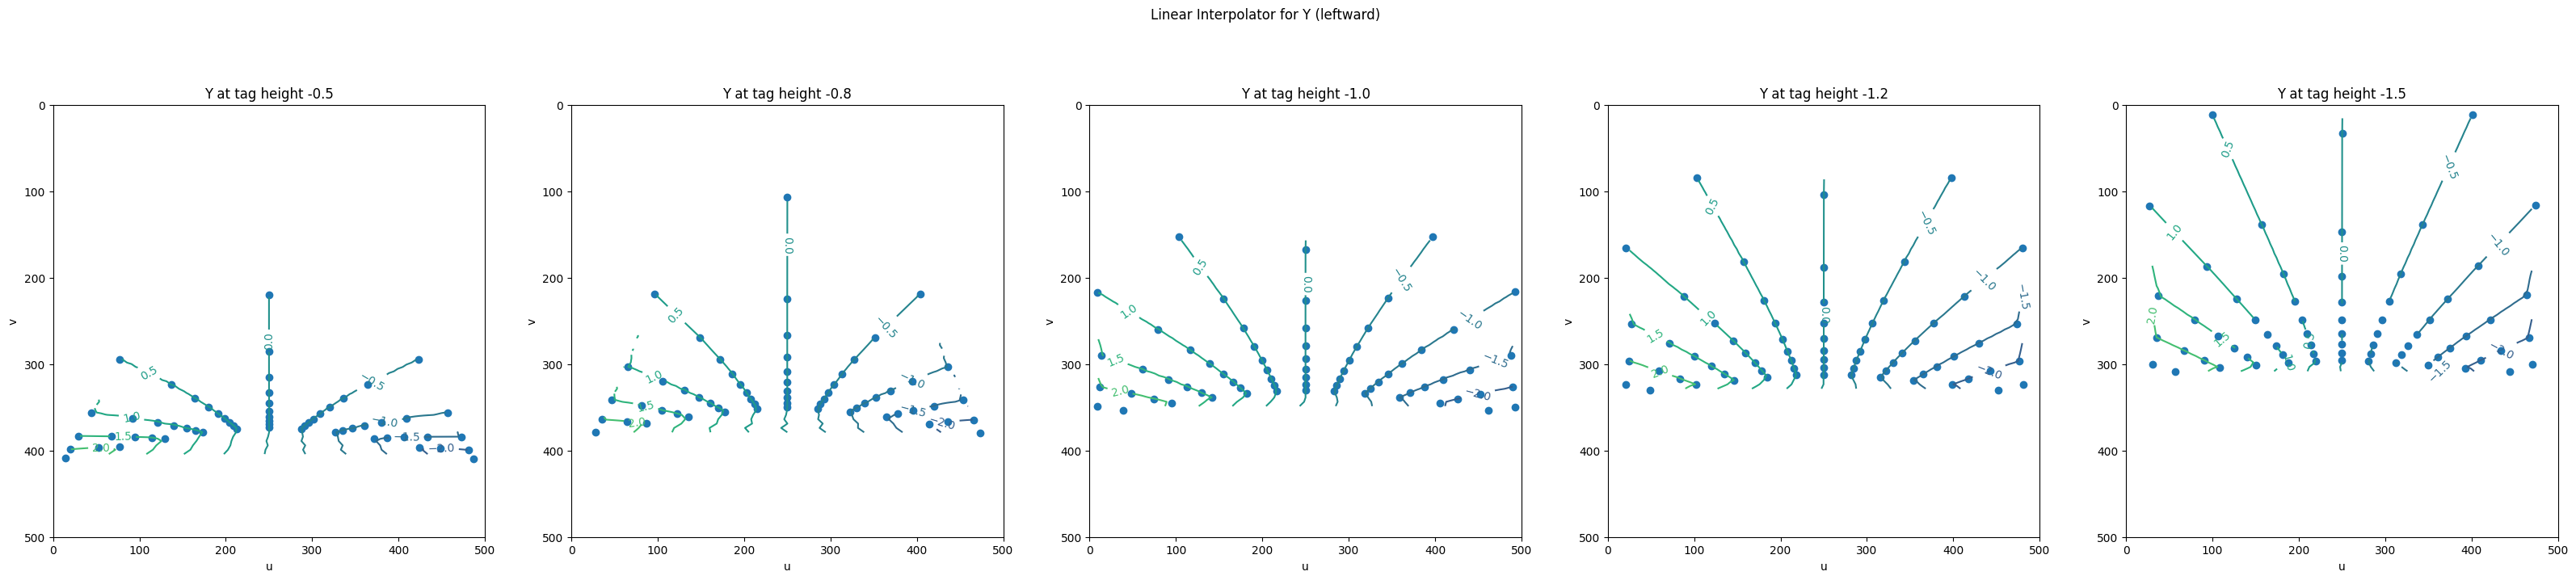

In [64]:
u_i = np.linspace(0,500,100)
v_i = np.linspace(0,500,100)

u_col = u_i.reshape(1,-1).T
v_col = v_i.reshape(1,-1).T

x_contour_space = np.linspace(0.5, 5, 10)
y_contour_space = np.linspace(-5, 5, 21)


# for X
fig, ax = plt.subplots(1, y_space_cv.size, figsize=(40, 8))
fig.suptitle('Linear Interpolator for X (forward)')
for i, tag_height in enumerate(y_space_cv):
    # the tag size is not independent of uvZ, which is good for prediction
    # but not good for generating test data.
    # but the linear interpolator doesn't extrapolate anyway, so
    # we can use the training data to visualize the contours.
    uvdZXY_nwu_for_height = uvdZXY_nwu[np.isclose(uvdZXY_nwu[:,3], -tag_height)]
    uvdZ_nwu_for_height = uvdZXY_nwu_for_height[:,(0,1,2,3)]

    predictedXY_nwu_for_height = uvdZ_nwu_to_XY_nwu_linear(uvdZ_nwu_for_height)


    predictedX_nwu_for_height = predictedXY_nwu_for_height[:, 0]
    u_for_height = uvdZ_nwu_for_height[:, 0]
    # print(u_for_height.shape)
    v_for_height = uvdZ_nwu_for_height[:, 1]
    X_nwu_i = interp.griddata(
        (u_for_height, v_for_height),
        predictedX_nwu_for_height,
        (u_i[None, :], v_i[:, None]),
        method="linear",
    )

    CS = ax[i].contour(u_i, v_i, X_nwu_i, x_contour_space)
    plt.clabel(CS, inline=1, fontsize=10)
    ax[i].set_xlabel("u")
    ax[i].set_ylabel("v")
    ax[i].set_title(f"X at tag height {tag_height:.1f}")
    ax[i].set_aspect("equal")
    ax[i].set_xlim(0, 500)
    ax[i].set_ylim(0, 500)
    ax[i].invert_yaxis()

    # overlay the ground truth
    for_height = uvdZXY_nwu[np.isclose(uvdZXY_nwu[:, 3], -tag_height)]
    uuu = for_height.T[0]
    vvv = for_height.T[1]
    ax[i].scatter(uuu, vvv)

plt.show()




# for Y
fig, ax = plt.subplots(1, y_space_cv.size, figsize=(40, 8))
fig.suptitle('Linear Interpolator for Y (leftward)')
for i, tag_height in enumerate(y_space_cv):    

    uvdZXY_nwu_for_height = uvdZXY_nwu[np.isclose(uvdZXY_nwu[:,3], -tag_height)]
    uvdZ_nwu_for_height = uvdZXY_nwu_for_height[:,(0,1,2,3)]

    predictedXY_nwu_for_height = uvdZ_nwu_to_XY_nwu_linear(uvdZ_nwu_for_height)

    predictedY_nwu_for_height = predictedXY_nwu_for_height[:, 1]
    Y_nwu_i = interp.griddata(
        (uvdZ_nwu_for_height[:, 0], uvdZ_nwu_for_height[:, 1]),
        predictedY_nwu_for_height,
        (u_i[None, :], v_i[:, None]),
        method="linear",
    )

    CS = ax[i].contour(u_i, v_i, Y_nwu_i, y_contour_space)
    plt.clabel(CS, inline=1, fontsize=10)
    ax[i].set_xlabel("u")
    ax[i].set_ylabel("v")
    ax[i].set_title(f"Y at tag height {tag_height:.1f}")
    ax[i].set_aspect("equal")
    ax[i].set_xlim(0, 500)
    ax[i].set_ylim(0, 500)
    ax[i].invert_yaxis()

    # overlay the ground truth
    for_height = uvdZXY_nwu[np.isclose(uvdZXY_nwu[:, 3], -tag_height)]
    uuu = for_height.T[0]
    vvv = for_height.T[1]
    ax[i].scatter(uuu, vvv)
plt.show()









### RBFInterpolator performance

This shows about 10 us on my laptop, which is a 3 GHz i7; a Raspberry Pi 4 runs at 1.8 GHz, so say it's half as fast, so the interpolation might take 20 us.

Compare this to the previous design which took 13 **milliseconds** to undistort the whole frame, and then the RoboRIO (much slower) would do the pose transformation.

Note: with a lot of points, RBFInterpolator goes REALLY slowly, and the "neighbors" thing only helps a little: neighbors = 10 => 200 us

the linear interpolator works fine with lots of points: 10 us (20x faster!)

In [65]:

t1 = time.time()
n = 100000
for i in range(n):
    uvdZ_nwu_to_XY_nwu_linear([[250.0, 250.0, 10, 1.00]])
t2 = time.time()
print(f"linear duration (sec) {(t2 - t1):.2f}")
print(f"linear duration per prediction (microsec) {(1e6*(t2-t1)/n):.2f}")

linear duration (sec) 0.86
linear duration per prediction (microsec) 8.59


### References

see more on [projectpoints](https://forum.opencv.org/t/understanding-the-functions-projectpoints-and-undistortpoints/10847)

and an example of [interpolation](https://stackoverflow.com/questions/37872171/how-can-i-perform-two-dimensional-interpolation-using-scipy)